In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots

In [9]:
def fullseed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True


In [10]:
seed = 1344
fullseed(seed)

# Transfer learning

**ConvNet as fixed feature extractor.** Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.


**Fine-tuning the ConvNet.** The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.

**New dataset is small and similar to original dataset**. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.


**New dataset is large and similar to the original dataset**. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.


**New dataset is small but very different from the original dataset**. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.


**New dataset is large and very different from the original dataset**. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

Source: https://cs231n.github.io/transfer-learning/

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**cats** and **dogs**. We have  200 training images each for cats and dogs.
There are 70 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of https://huggingface.co/datasets/cats_vs_dogs.

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=x=="train", num_workers=4, worker_init_fn=fullseed(seed))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
dataset_sizes

{'train': 400, 'val': 140}

Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



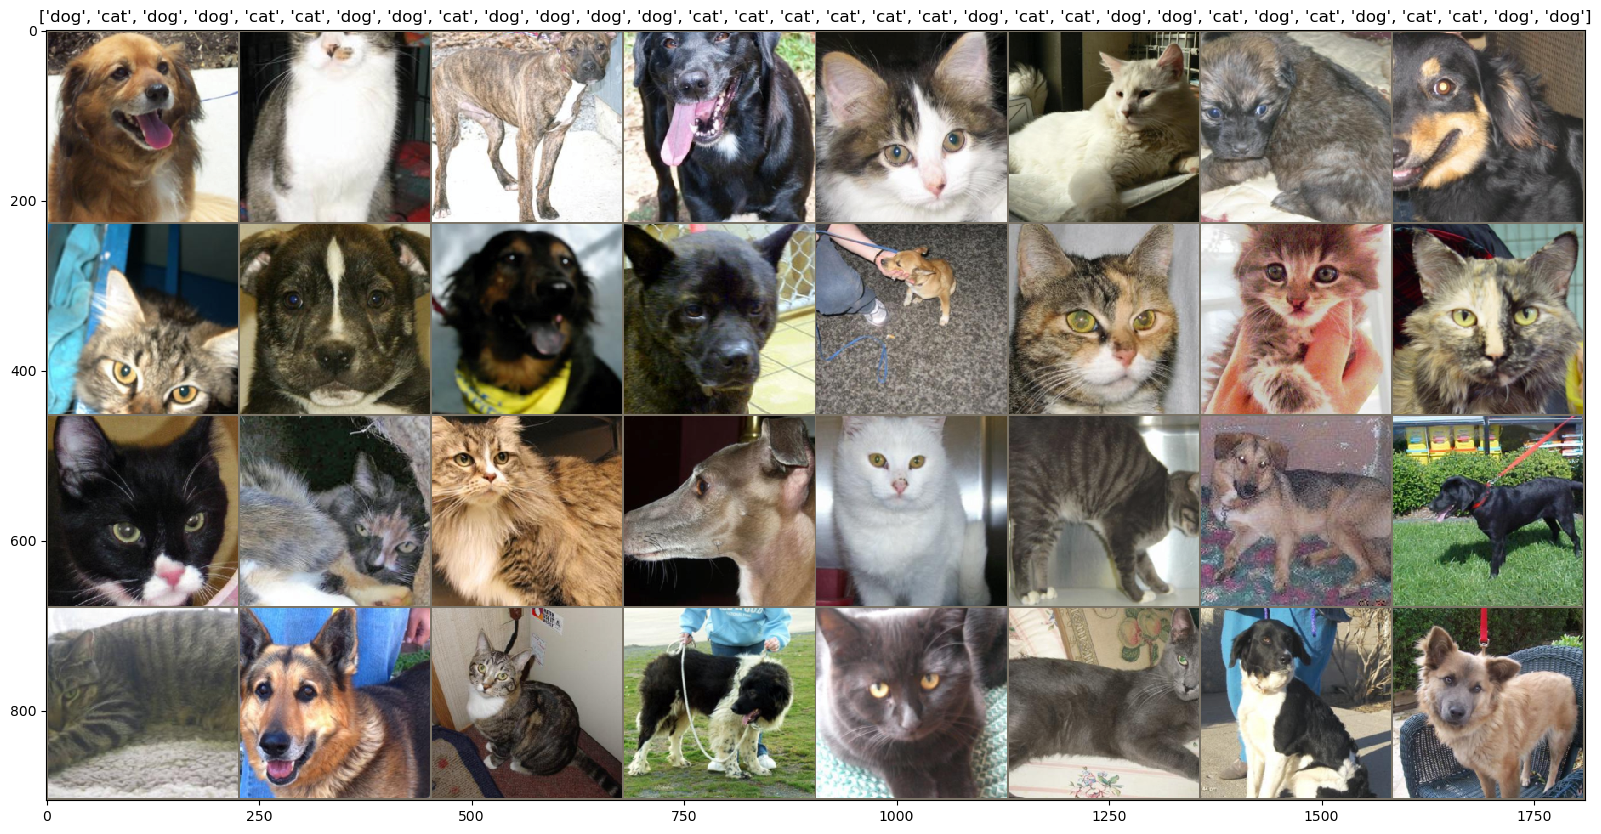

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, step_every_batch=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lrs = []
    losses = {"train": [], "val": []}
    metrics = {"train": [], "val": []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                lrs.append(optimizer.param_groups[0]['lr'])
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler and step_every_batch:
                            scheduler.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler and not step_every_batch:
                    scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_acc.detach().cpu().numpy())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    fig, axs = plt.subplots(1, 3)
    
    
    axs[0].plot(range(len(lrs)), lrs)
    axs[0].legend(["lr"])
    
    
    for phase in ['train', 'val']:
        axs[1].plot(range(num_epochs), np.clip(losses[phase],a_min=0, a_max=1))
    axs[1].legend(["train loss", "val loss"])
    
    for phase in ['train', 'val']:
        axs[2].plot(range(num_epochs), metrics[phase])
    axs[2].legend(["train acc", "val acc"])
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


Epoch 0/9
----------
train Loss: 0.5754 Acc: 0.6825
val Loss: 0.2472 Acc: 0.9643

Epoch 1/9
----------
train Loss: 0.1748 Acc: 0.9625
val Loss: 0.1194 Acc: 0.9643

Epoch 2/9
----------
train Loss: 0.0921 Acc: 0.9800
val Loss: 0.0809 Acc: 0.9786

Epoch 3/9
----------
train Loss: 0.0682 Acc: 0.9900
val Loss: 0.0773 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.0355 Acc: 1.0000
val Loss: 0.0706 Acc: 0.9714

Epoch 5/9
----------
train Loss: 0.0282 Acc: 1.0000
val Loss: 0.0749 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.0306 Acc: 0.9975
val Loss: 0.0750 Acc: 0.9643

Epoch 7/9
----------
train Loss: 0.0244 Acc: 1.0000
val Loss: 0.0690 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.0319 Acc: 1.0000
val Loss: 0.0734 Acc: 0.9643

Epoch 9/9
----------
train Loss: 0.0239 Acc: 1.0000
val Loss: 0.0656 Acc: 0.9714

Training complete in 0m 21s
Best val Acc: 0.978571


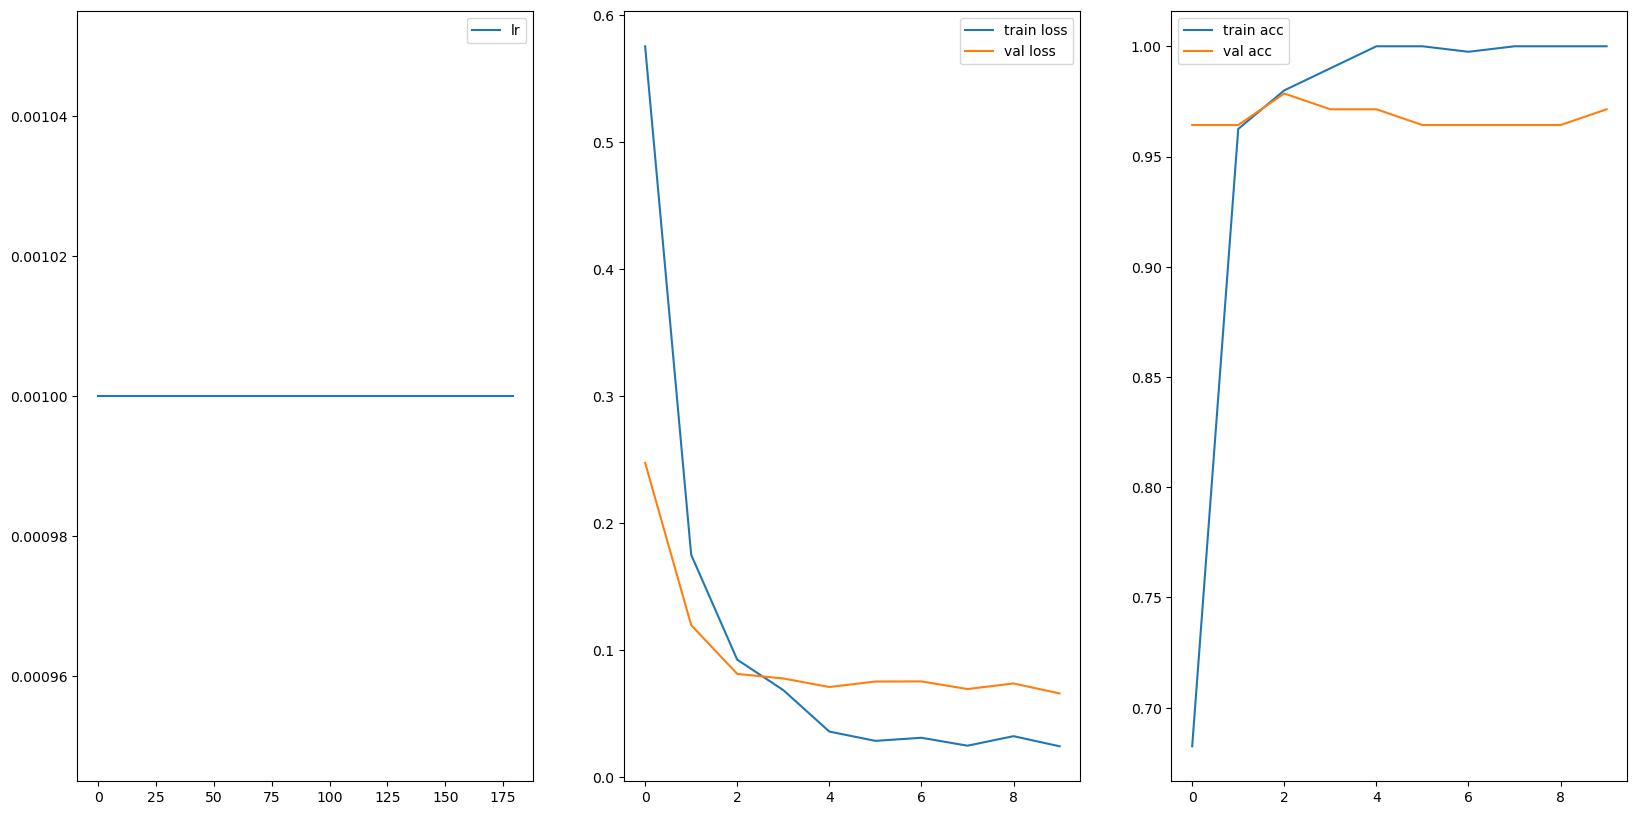

In [17]:
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10)

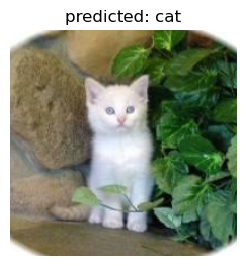

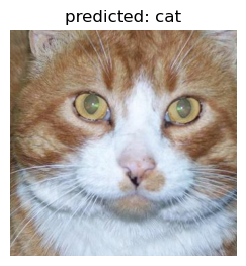

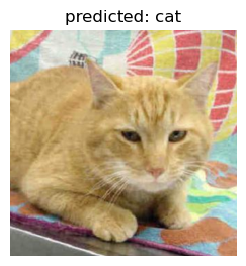

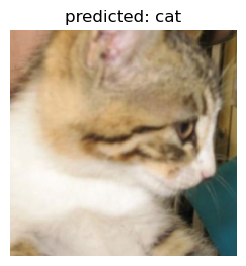

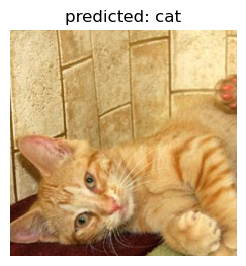

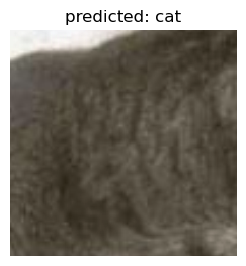

In [18]:
visualize_model(model_ft)

# Add augmentations

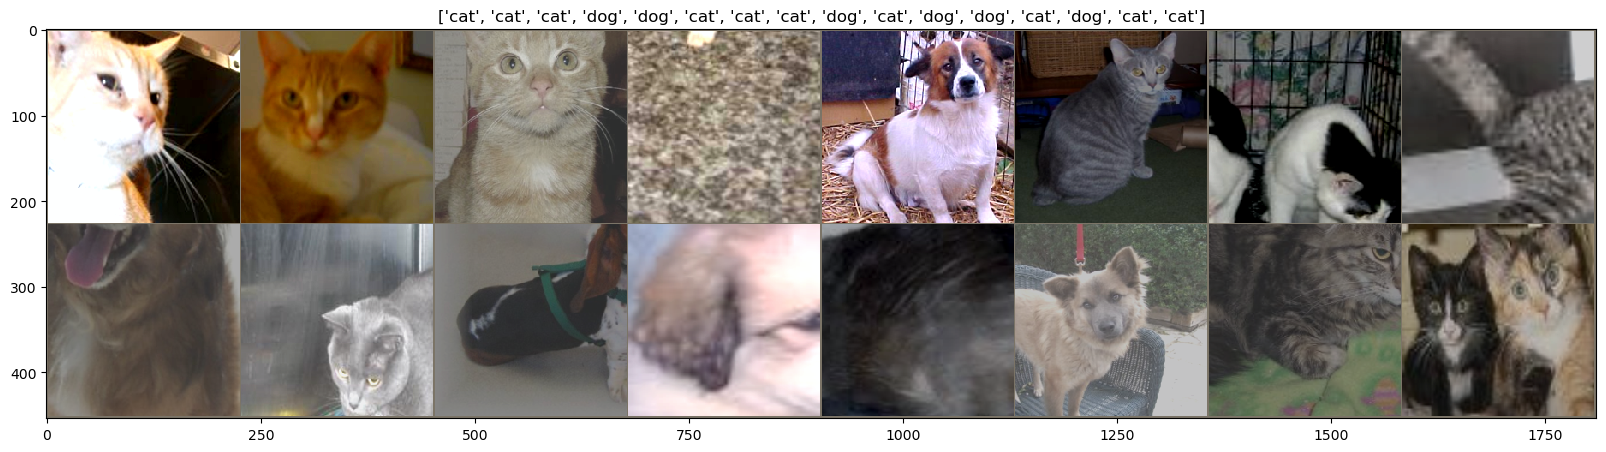

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs//'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/19
----------
train Loss: 0.4287 Acc: 0.8275
val Loss: 0.1589 Acc: 0.9500

Epoch 1/19
----------
train Loss: 0.2528 Acc: 0.8850
val Loss: 0.0884 Acc: 0.9714

Epoch 2/19
----------
train Loss: 0.1710 Acc: 0.9200
val Loss: 0.0821 Acc: 0.9786

Epoch 3/19
----------
train Loss: 0.1722 Acc: 0.9425
val Loss: 0.0722 Acc: 0.9786

Epoch 4/19
----------
train Loss: 0.1660 Acc: 0.9350
val Loss: 0.0751 Acc: 0.9643

Epoch 5/19
----------
train Loss: 0.1549 Acc: 0.9425
val Loss: 0.0650 Acc: 0.9786

Epoch 6/19
----------
train Loss: 0.1635 Acc: 0.9325
val Loss: 0.0580 Acc: 0.9857

Epoch 7/19
----------
train Loss: 0.2214 Acc: 0.9125
val Loss: 0.0573 Acc: 0.9786

Epoch 8/19
----------
train Loss: 0.2400 Acc: 0.9000
val Loss: 0.0630 Acc: 0.9786

Epoch 9/19
----------
train Loss: 0.1542 Acc: 0.9400
val Loss: 0.0774 Acc: 0.9786

Epoch 10/19
----------
train Loss: 0.1652 Acc: 0.9400
val Loss: 0.0740 Acc: 0.9786

Epoch 11/19
----------
train Loss: 0.1436 Acc: 0.9425
val Loss: 0.0699 Acc: 0.9857

Ep

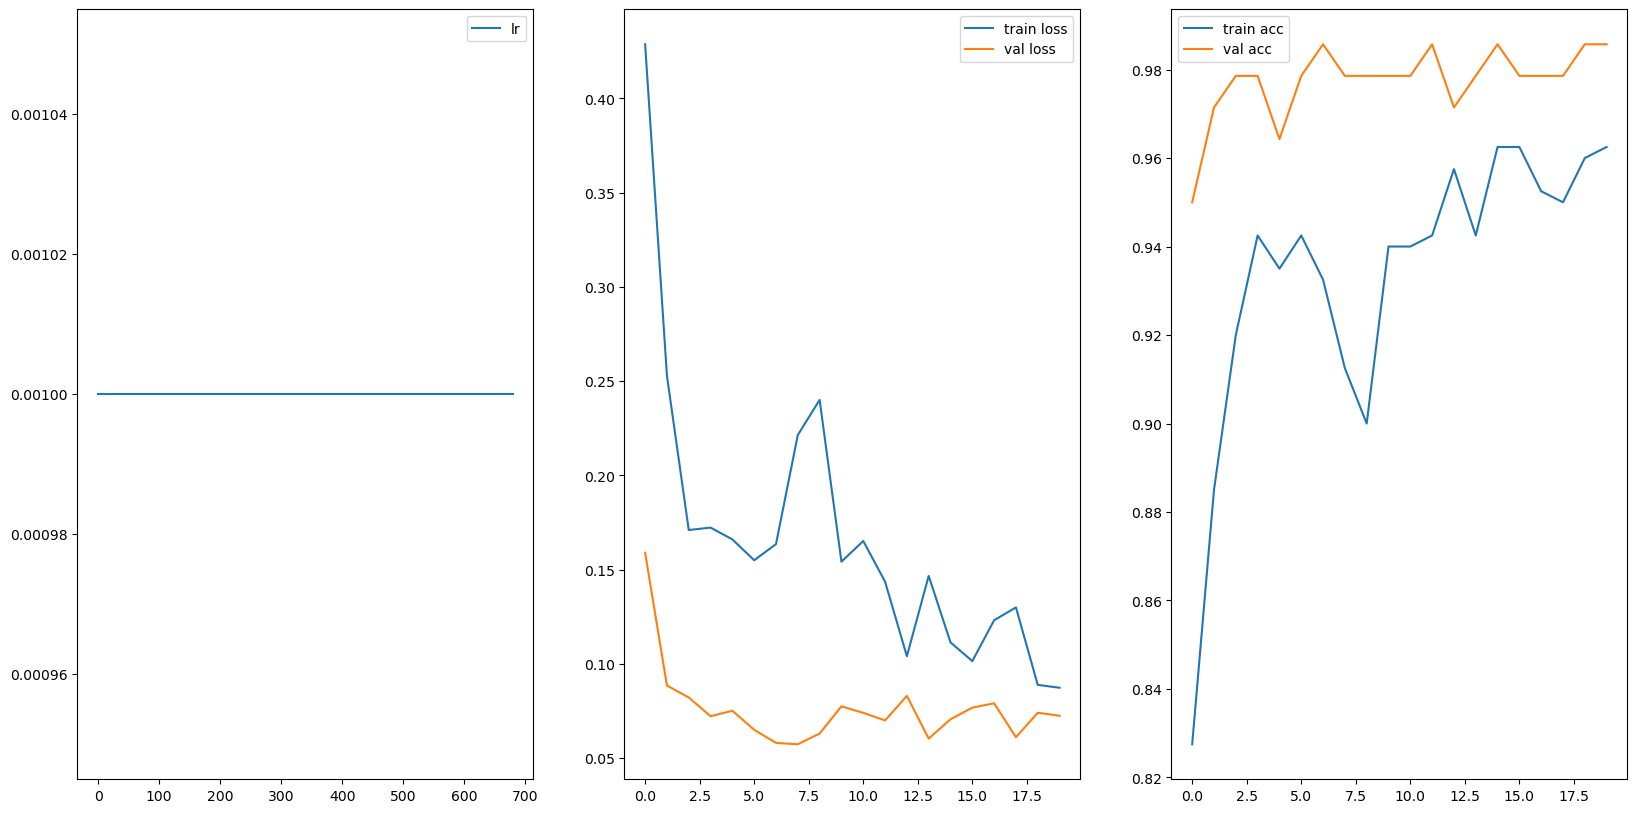

In [29]:
model2 = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(class_names))

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft2 = train_model(model2, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=20)

# Add scheduling

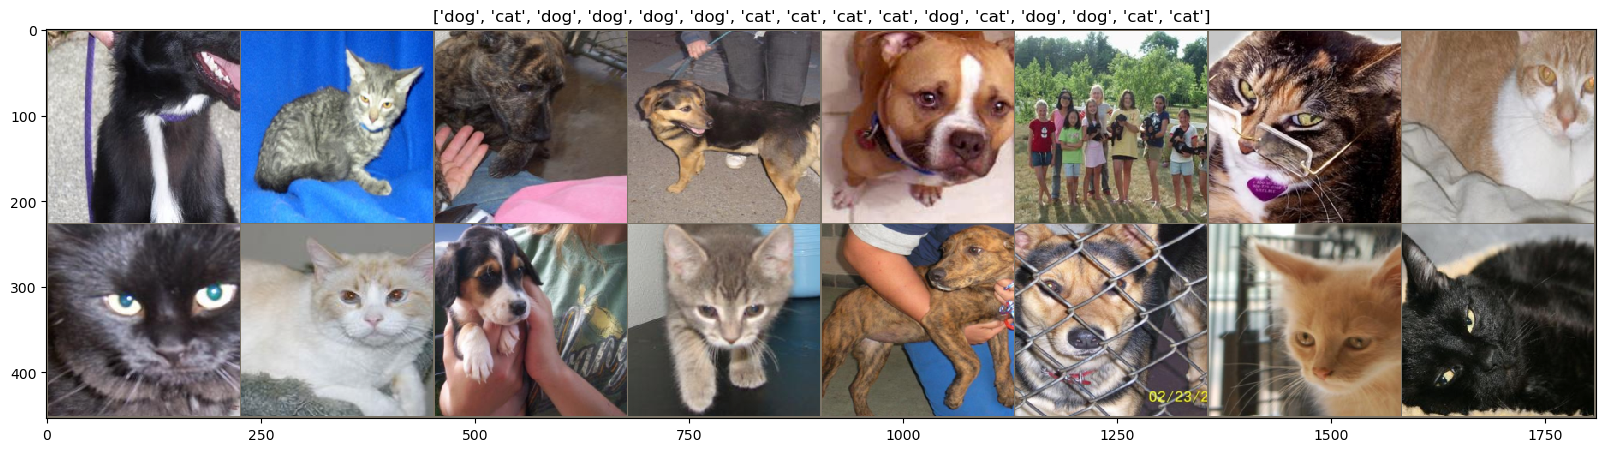

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/14
----------
train Loss: 0.4523 Acc: 0.7750
val Loss: 0.1058 Acc: 0.9857

Epoch 1/14
----------
train Loss: 0.1924 Acc: 0.9300
val Loss: 0.0709 Acc: 0.9786

Epoch 2/14
----------
train Loss: 0.1540 Acc: 0.9400
val Loss: 0.0520 Acc: 0.9786

Epoch 3/14
----------
train Loss: 0.1506 Acc: 0.9375
val Loss: 0.0593 Acc: 0.9857

Epoch 4/14
----------
train Loss: 0.1733 Acc: 0.9275
val Loss: 0.0559 Acc: 0.9714

Epoch 5/14
----------
train Loss: 0.1128 Acc: 0.9525
val Loss: 0.0544 Acc: 0.9786

Epoch 6/14
----------
train Loss: 0.1346 Acc: 0.9475
val Loss: 0.0525 Acc: 0.9786

Epoch 7/14
----------
train Loss: 0.1394 Acc: 0.9275
val Loss: 0.0537 Acc: 0.9786

Epoch 8/14
----------
train Loss: 0.1277 Acc: 0.9500
val Loss: 0.0520 Acc: 0.9786

Epoch 9/14
----------
train Loss: 0.1215 Acc: 0.9550
val Loss: 0.0480 Acc: 0.9857

Epoch 10/14
----------
train Loss: 0.1234 Acc: 0.9500
val Loss: 0.0511 Acc: 0.9714

Epoch 11/14
----------
train Loss: 0.1368 Acc: 0.9450
val Loss: 0.0496 Acc: 0.9786

Ep

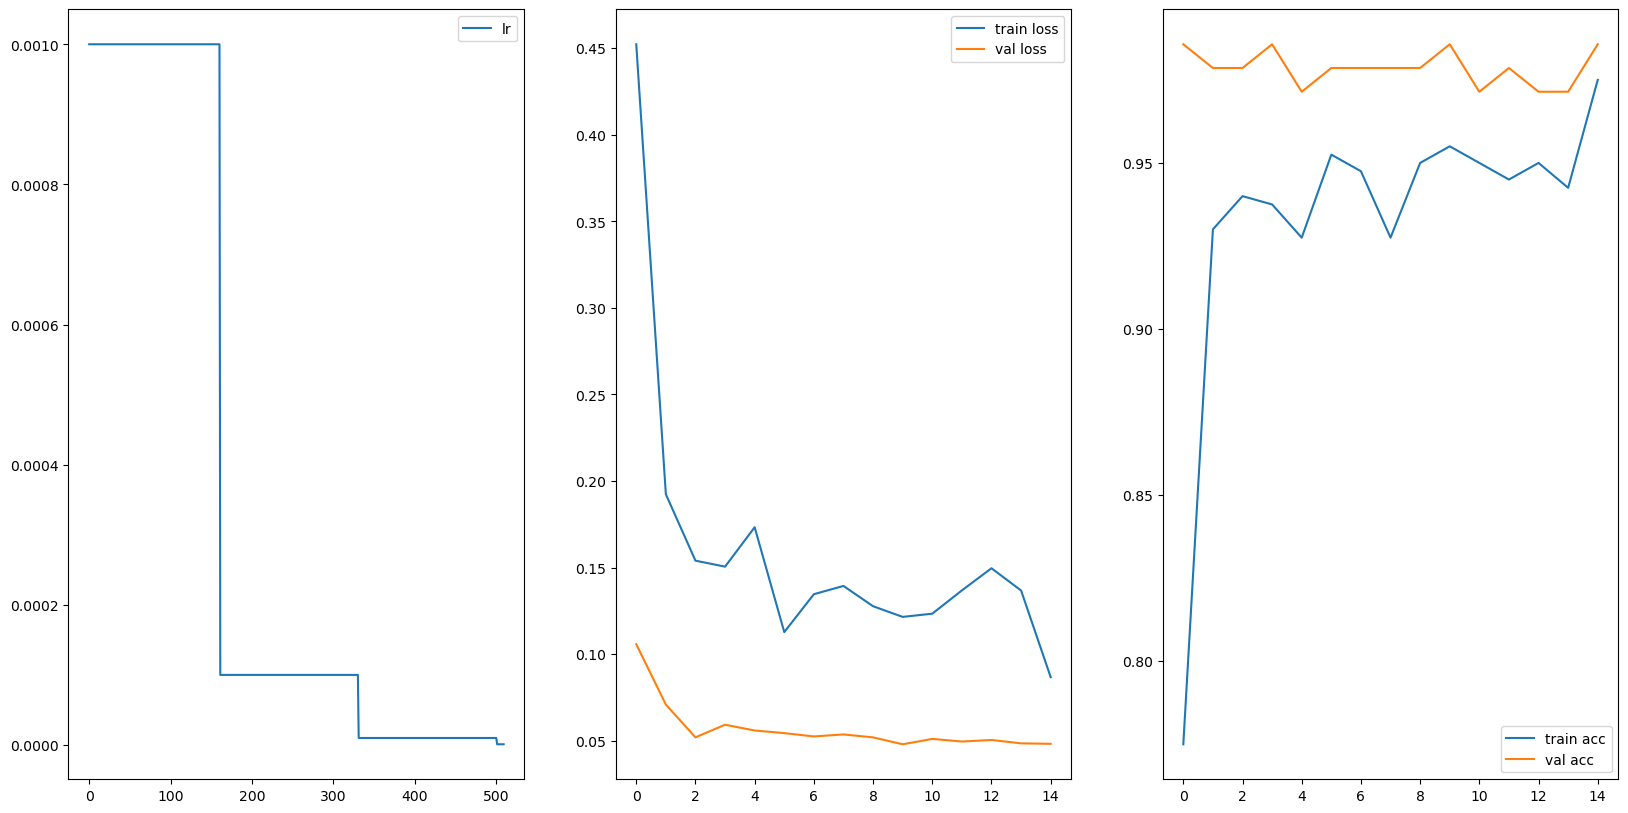

In [31]:
model3 = models.resnet18(pretrained=True)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(class_names))

model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

model_ft3 = train_model(model3, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=15)

# Bonus: LR test

Learning rate range test is a method for discovering the largest learning rate values that can be used to train a model without divergence. Data scientists are often interested in this information because large learning rates lead to faster model convergence than a small learning rates.

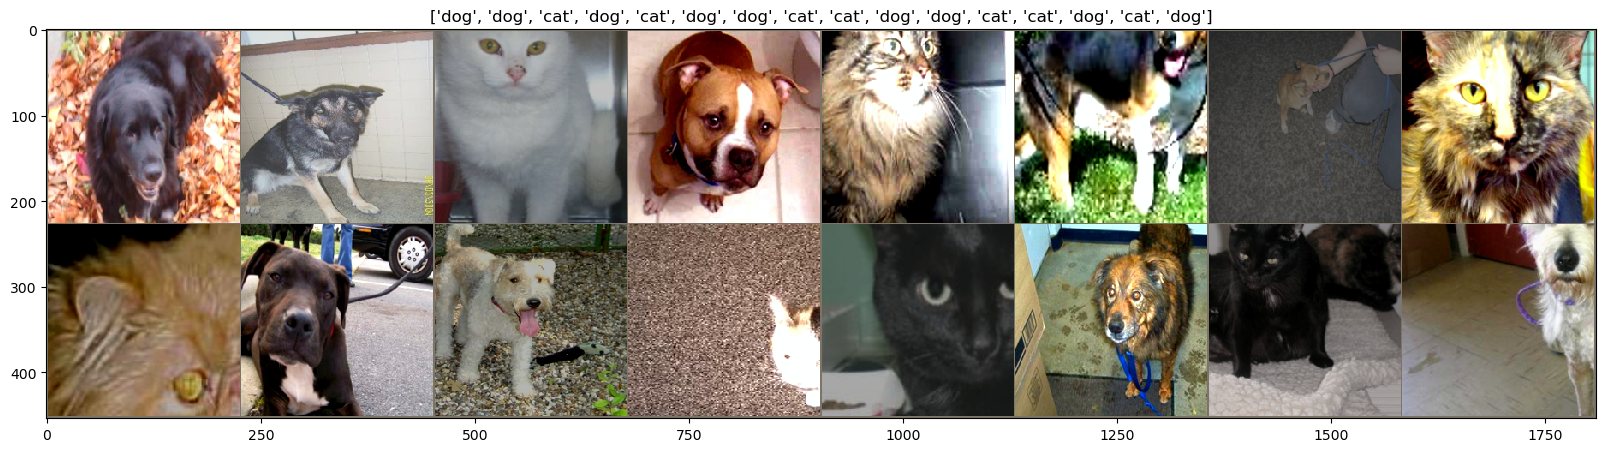

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
N = len(dataloaders['train'])*10 # за 10 епох робимо 250 кроків

In [25]:
N

250

In [26]:
# 1e-6*gamma^250 = 1
# gamma^250 = 1e6
gamma = 1e6**(1/N)
gamma

1.0568175092136585

Epoch 0/9
----------
train Loss: 0.7540 Acc: 0.4600
val Loss: 0.7433 Acc: 0.4714

Epoch 1/9
----------
train Loss: 0.7350 Acc: 0.5000
val Loss: 0.7068 Acc: 0.4929

Epoch 2/9
----------
train Loss: 0.7049 Acc: 0.5300
val Loss: 0.6074 Acc: 0.6643

Epoch 3/9
----------
train Loss: 0.5839 Acc: 0.7125
val Loss: 0.3855 Acc: 0.9071

Epoch 4/9
----------
train Loss: 0.3725 Acc: 0.8700
val Loss: 0.1771 Acc: 0.9571

Epoch 5/9
----------
train Loss: 0.2840 Acc: 0.8850
val Loss: 0.0584 Acc: 0.9786

Epoch 6/9
----------
train Loss: 0.5432 Acc: 0.8650
val Loss: 1.3906 Acc: 0.6857

Epoch 7/9
----------
train Loss: 4.2670 Acc: 0.5275
val Loss: 861548.1768 Acc: 0.5000

Epoch 8/9
----------
train Loss: 5.9713 Acc: 0.4700
val Loss: 10931.0584 Acc: 0.5000

Epoch 9/9
----------
train Loss: 2.6139 Acc: 0.4700
val Loss: 1.3996 Acc: 0.5857

Training complete in 0m 19s
Best val Acc: 0.978571


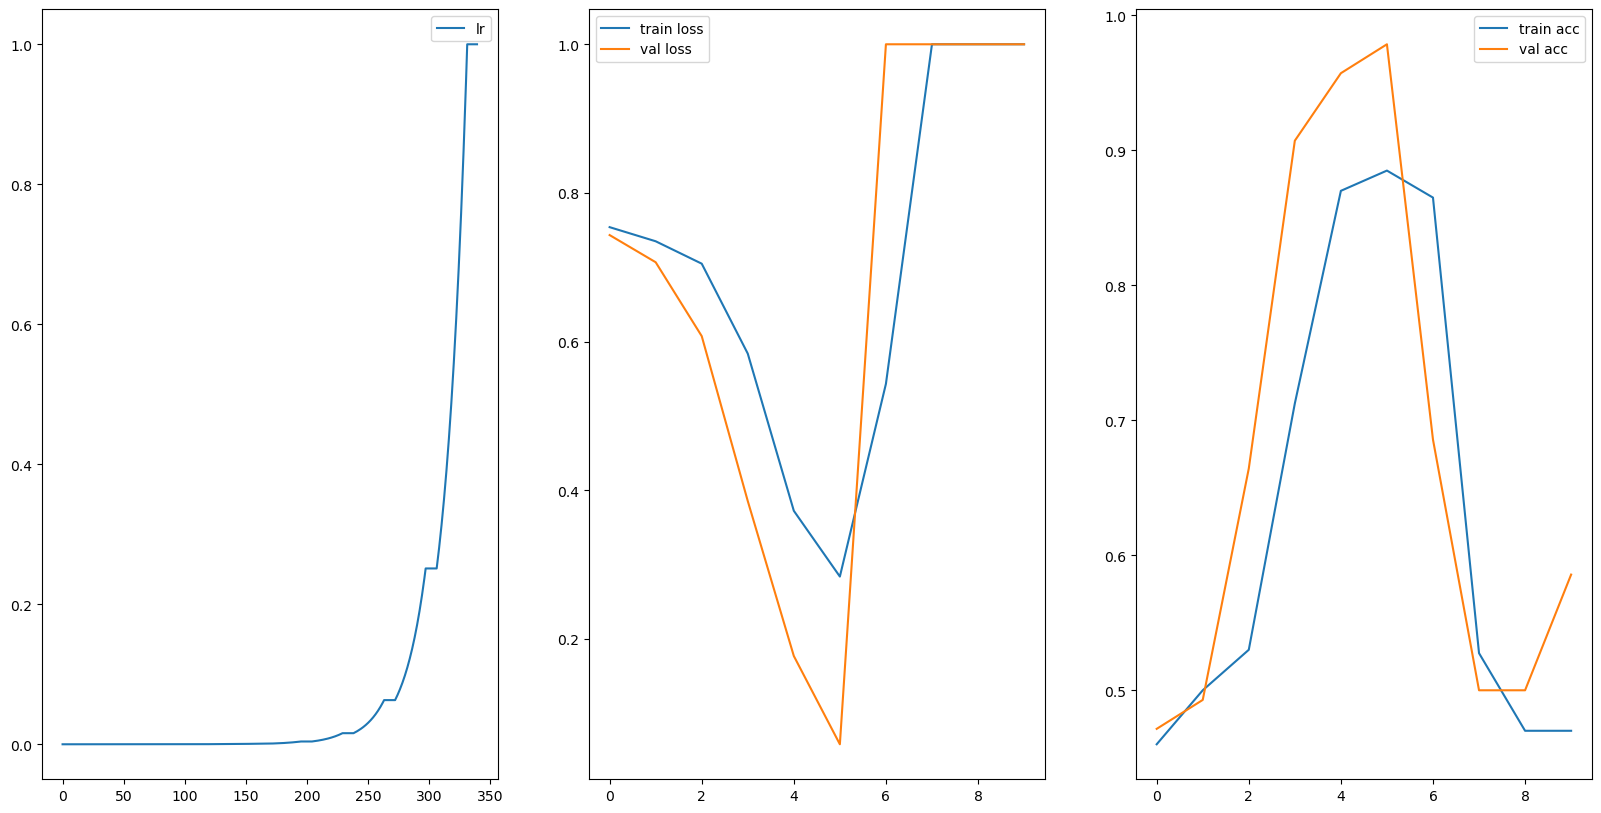

In [27]:
model4 = models.resnet18(pretrained=True)
num_ftrs = model4.fc.in_features
model4.fc = nn.Linear(num_ftrs, len(class_names))

model4 = model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(), lr=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

model_ft4 = train_model(model4, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10, step_every_batch=True)

In [28]:
#вибрали ~~~4.5й крок

1e-6*gamma**(16*4.5)

5.345643593969717e-05

# Homework:  use pretrained model as feature extractor instead of finetuning and compare results

## Hint
You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.